# Convolutional Neural Networks

## Imports and constants

In [68]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler
import torch.nn as nn
import torch.optim as optim
from torchmetrics import Accuracy
from torchinfo import summary
from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from datetime import datetime
import os
import shutil
import subprocess
import webbrowser
import time
import matplotlib.pyplot as plt
import csv

import torch.nn.init as init
import numpy as np

import matplotlib.patches as mpatches
from sklearn.manifold import TSNE

import pandas as pd

from matplotlib.colors import ListedColormap

from torch.optim.lr_scheduler import StepLR




TENSORBOARD = False
EPOCHS = 15
BATCH_SIZE = 32
models_path = 'models'
plots_path = 'graphs'
runs_path = 'runs'

## Load data & initial preprocessing

In [3]:
'''
#1 Download the FashionMNIST train and test datasets

#2 Compute the mean and std of train images

#3 Define transformations:
  -ToTensor: Converts images to tensors
  -Normalise: Normalizes images to have mean 0 and std 1

#4 Apply transforms to the train and test datasets
Train dataset:
  -RandomRotation: Randomly rotates the images only 10 degrees to add some variation without 
  changing significantly the uniformality of the dataset.
  -RandomHorizontalFlip: Randomly flips 20% of the images horizontally . . .
  -RandomResizedCrop: Randomly zooming into or cropping the images to help the model focus on different parts of the image.

#5 Split the train set into training and validation sets

#6 Create iterators for our datasets using DataLoader

#7 Select device for training. Selects GPU or MPS if available, otherwise uses CPU.

#8 Index dataset's labels to image descriptors
'''

#1
train_set_full = datasets.FashionMNIST( root='./datasets/', train=True, download=True, transform=transforms.ToTensor())
test_set = datasets.FashionMNIST(root='./datasets', train=False, download=True, transform=transforms.ToTensor())

#2
imgs = torch.stack([img for img, _ in train_set_full], dim=0)
mean = imgs.mean()
std = imgs.std()

#3
train_val_set_transforms_aug = transforms.Compose([
                                      #  transforms.RandomRotation(degrees=10),
                                       transforms.RandomHorizontalFlip(p=0.25),
                                       transforms.ColorJitter(brightness=0.2, contrast=0.2),
                                       
                                       #  transforms.RandomGrayscale(p=0.2),
                                      #  transforms.RandomResizedCrop(size=(28, 28), scale=(0.8, 1.0)),
                                      #  transforms.RandomInvert(p=0.8),
                                      transforms.RandomAutocontrast(p=0.2),
                                      transforms.RandomSolarize(p=0.2, threshold=15),
                                       transforms.ToTensor(),
                                      #  transforms.RandomErasing(p=0.2, scale=(0.02, 0.1), ratio=(0.1, 3.3), value=0),
                                       transforms.Normalize(mean=mean, std=std)
                                      ]
                                      )

test_set_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean=mean, std=std)
                                      ])

#4
train_val_dataset = datasets.FashionMNIST(root="./datasets/", train=True, download=True, transform=train_val_set_transforms_aug)
test_dataset = datasets.FashionMNIST(root="./datasets/", train=False, download=True, transform=test_set_transforms)


#5
train_size = int(0.8 * len(train_val_dataset))
validation_size = len(train_val_dataset) - train_size
train_set, validation_set = random_split(train_val_dataset, [train_size, validation_size])

#6
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

#7
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

#8
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

Using cpu device


In [4]:
# If tensorboard and there is a "runs" folder, delete it to start over
if TENSORBOARD:
    def delete_folder(folder_path):
        # Check if the folder exists
        if os.path.exists(folder_path) and os.path.isdir(folder_path):
            # Delete the folder
            shutil.rmtree(folder_path)
            print(f"Folder '{folder_path}' has been deleted.")
        else:
            print(f"Folder '{folder_path}' does not exist.")

    folder_to_delete = runs_path
    delete_folder(folder_to_delete)

## LeNet baseline

### Define the LeNet model

In [5]:
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.first_wave = nn.Sequential(
              nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),   # 28x28 -> 32x32 -> 28x28
              nn.ReLU(),
              nn.AvgPool2d(kernel_size=2, stride=2),  # 28x28 -> 14x14
        )

        self.second_wave = nn.Sequential(      
              nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),  # 14x14 -> 10x10
              nn.ReLU(),
              nn.AvgPool2d(kernel_size=2, stride=2),  # 10x10 -> 5x5
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10),
        )
        
        # Initialize weights using Kaiming Uniform
        self._initialize_weights()
        
        # Additional output layers
        self.aux_output1 = nn.Linear(6*14*14, 10)  # After first pooling
        self.aux_output2 = nn.Linear(16*5*5, 10)   # After second pooling

    def forward(self, x):
        x = self.first_wave(x)
        aux1 = self.aux_output1(x.view(x.size(0), -1))
        
        x = self.second_wave(x)
        aux2 = self.aux_output2(x.view(x.size(0), -1))
        
        x = self.classifier(x)
        
        return x, aux1, aux2

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def get_features(self, x):
        # Pass through the first wave of layers
        x = self.first_wave(x)
        
        # Pass through the second wave of layers
        x = self.second_wave(x)
        
        # Flatten the output for the classifier
        x = x.view(x.size(0), -1)

        # Pass through all layers of the classifier except the last one
        for layer in self.classifier[:-1]:
            x = layer(x)

        return x


In [6]:
model_lenet5 = LeNet5()

summary(model=model_lenet5, input_size=(1, 1, 28, 28), col_width=20,
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LeNet5 (LeNet5)                          [1, 1, 28, 28]       [1, 10]              --                   True
├─Sequential (first_wave)                [1, 1, 28, 28]       [1, 6, 14, 14]       --                   True
│    └─Conv2d (0)                        [1, 1, 28, 28]       [1, 6, 28, 28]       156                  True
│    └─ReLU (1)                          [1, 6, 28, 28]       [1, 6, 28, 28]       --                   --
│    └─AvgPool2d (2)                     [1, 6, 28, 28]       [1, 6, 14, 14]       --                   --
├─Linear (aux_output1)                   [1, 1176]            [1, 10]              11,770               True
├─Sequential (second_wave)               [1, 6, 14, 14]       [1, 16, 5, 5]        --                   True
│    └─Conv2d (0)                        [1, 6, 14, 14]       [1, 16, 10, 10]      2,416                True
│    └─ReLU (1)   

In [7]:
# Define Loss Function
loss_fn = nn.CrossEntropyLoss()
# Define Optimizer
optimizer = optim.Adam(model_lenet5.parameters(), lr=0.001)
# Define output accuracy function
accuracy = Accuracy(task='multiclass', num_classes=10)

### Train LeNet model

In [8]:
# Experiment tracking setup using TensorBoard
if TENSORBOARD:
    timestamp = datetime.now().strftime("%Y-%m-%d")
    experiment_name = "MNIST"
    model_name = "LeNet5"
    log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
    writer = SummaryWriter(log_dir) # Initialize a TensorBoard writer for logging

    # Start TensorBoard using subprocess
    tensorboard_process = subprocess.Popen(["tensorboard", "--logdir", "runs", "--port", "6007"])

# Move accuracy and model to the appropriate device
accuracy = accuracy.to(device)
model_lenet5 = model_lenet5.to(device)

history_lenet5 = {'train_loss':[], 'val_loss':[], 'train_acc': [], 'val_acc': []}
epoch_count = 0

best_val_acc = 0.0
best_epoch = 0
best_model_state = None

for epoch in tqdm(range(EPOCHS)): # Progress bar for epochs
    # Initialize trining loss and accuracy
    train_loss_v0, train_acc_v0 = 0.0, 0.0
    
    epoch_count += 1
    
    # Iterating over batches of training data
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        # Set model to training mode
        model_lenet5.train()
        # Forward pass: compute predictions
        y_pred, _, _ = model_lenet5.forward(X)
        #Calculate the current batch loss and accuracy and aggregate it to the total variables
        loss = loss_fn(y_pred, y)
        train_loss_v0 += loss.item()
        acc = accuracy(y_pred, y)
        train_acc_v0 += acc
        # Zero out gradients
        optimizer.zero_grad()
        # Backpropagate the loss
        loss.backward()
        # Update model parameters
        optimizer.step()
        

    # Average training loss and accuracy over all batches
    train_loss_v0 /= len(train_loader)
    train_acc_v0 /= len(train_loader)
    # Keep history
    history_lenet5['train_loss'].append(train_loss_v0)
    history_lenet5['train_acc'].append(train_acc_v0)

    # Validation loop
    val_loss_v0, val_acc_v0 = 0.0, 0.0
    # Set model to evaluation mode
    model_lenet5.eval()
    with torch.inference_mode(): # Context manager for inference without gradient tracking
        for X, y in validation_loader:
            X, y = X.to(device), y.to(device)

            y_pred, _, _ = model_lenet5.forward(X)

            loss = loss_fn(y_pred, y)
            val_loss_v0 += loss.item()

            acc = accuracy(y_pred, y)
            val_acc_v0 += acc

        # Average validation loss and accuracy over all batches
        val_loss_v0 /= len(validation_loader)
        val_acc_v0 /= len(validation_loader)
        # Keep history
        history_lenet5['val_loss'].append(val_loss_v0)
        history_lenet5['val_acc'].append(val_acc_v0)
        
        # Check if the validation accuracy improved
        if val_acc_v0 > best_val_acc:
            best_val_acc = val_acc_v0
            # Save the best model state
            best_epoch = epoch
            best_model_state = model_lenet5.state_dict()

    if TENSORBOARD:
        # Log training and validation loss and accuracy to TensorBoard
        writer.add_scalars(main_tag="Loss", tag_scalar_dict={"train/loss": train_loss_v0, "val/loss": val_loss_v0}, global_step=epoch)
        writer.add_scalars(main_tag="Accuracy", tag_scalar_dict={"train/acc": train_acc_v0, "val/acc": val_acc_v0}, global_step=epoch)

        if epoch == 0:
            # Optionally, open a web browser tab. The time delay allows TensorBoard to start up.
            time.sleep(3)  # Wait for 3 seconds before opening the browser
            webbrowser.open("http://localhost:6007")

    print(f"Epoch: {epoch}| Train loss: {train_loss_v0: .5f}| Train acc: {train_acc_v0: .5f}| Val loss: {val_loss_v0: .5f}| Val acc: {val_acc_v0: .5f}")
    
# After training
if best_model_state is not None:
    model_lenet5.load_state_dict(best_model_state)
    # Cut the history up to the best epoch
    history_lenet5['train_loss'] = history_lenet5['train_loss'][:best_epoch + 1]
    history_lenet5['train_acc'] = history_lenet5['train_acc'][:best_epoch + 1]
    history_lenet5['val_loss'] = history_lenet5['val_loss'][:best_epoch + 1]
    history_lenet5['val_acc'] = history_lenet5['val_acc'][:best_epoch + 1]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0| Train loss:  0.56757| Train acc:  0.79413| Val loss:  0.44189| Val acc:  0.83800
Epoch: 1| Train loss:  0.40079| Train acc:  0.85281| Val loss:  0.39790| Val acc:  0.85500
Epoch: 2| Train loss:  0.35577| Train acc:  0.86871| Val loss:  0.35082| Val acc:  0.87475
Epoch: 3| Train loss:  0.33258| Train acc:  0.87727| Val loss:  0.35361| Val acc:  0.86933
Epoch: 4| Train loss:  0.31712| Train acc:  0.88404| Val loss:  0.33055| Val acc:  0.88517
Epoch: 5| Train loss:  0.29822| Train acc:  0.88854| Val loss:  0.31557| Val acc:  0.88392
Epoch: 6| Train loss:  0.28675| Train acc:  0.89392| Val loss:  0.31572| Val acc:  0.88483
Epoch: 7| Train loss:  0.27471| Train acc:  0.89860| Val loss:  0.31479| Val acc:  0.88408
Epoch: 8| Train loss:  0.26429| Train acc:  0.90244| Val loss:  0.30247| Val acc:  0.88842
Epoch: 9| Train loss:  0.25947| Train acc:  0.90283| Val loss:  0.29436| Val acc:  0.89725
Epoch: 10| Train loss:  0.25194| Train acc:  0.90544| Val loss:  0.29245| Val acc:  0.8945

### Visualize the descriptive layers

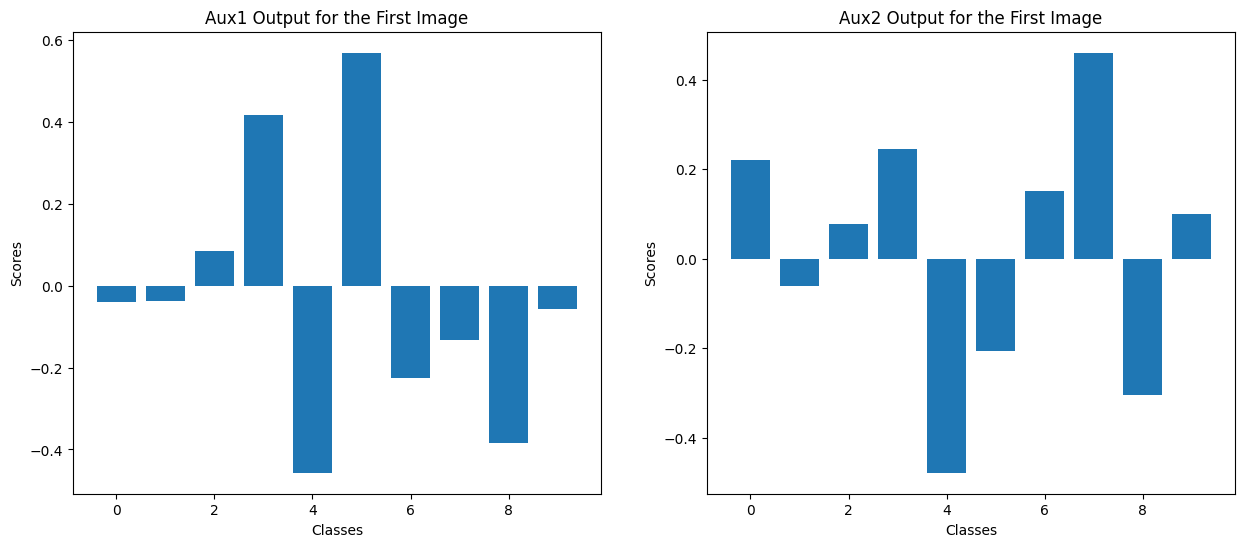

In [9]:
model_lenet5.eval()
with torch.no_grad():
    # Get one batch of data
    for images, _ in test_loader:
        images = images.to(device)
        _, aux1, aux2 = model_lenet5(images)

        # Select the first image in the batch for visualization
        scores_aux1 = aux1[0].cpu().numpy()
        scores_aux2 = aux2[0].cpu().numpy()

        # Plot
        plt.figure(figsize=(15, 6))
        
        plt.subplot(1, 2, 1)
        plt.title("Aux1 Output for the First Image")
        plt.bar(np.arange(10), scores_aux1)
        plt.xlabel('Classes')
        plt.ylabel('Scores')

        plt.subplot(1, 2, 2)
        plt.title("Aux2 Output for the First Image")
        plt.bar(np.arange(10), scores_aux2)
        plt.xlabel('Classes')
        plt.ylabel('Scores')

        plt.show()
        break  # Only visualize for the first batch


### Test in how many images the first Conv layer predicted the same as the second

In [10]:
total_samples = 0
matching_highest_scores = 0

model_lenet5.eval()
with torch.no_grad():
    for X, y in train_loader:
        X = X.to(device)
        _, aux1, aux2 = model_lenet5(X)

        # Get the indices of the max score for each sample in the batch
        max_indices_aux1 = torch.argmax(aux1, dim=1)
        max_indices_aux2 = torch.argmax(aux2, dim=1)

        # Count how many times the highest scoring classes match
        matches = torch.sum(max_indices_aux1 == max_indices_aux2)
        matching_highest_scores += matches.item()

        total_samples += X.size(0)

# Calculate the percentage
percentage_matching = (matching_highest_scores / total_samples) * 100
print(f"Percentage of matching highest scores: {percentage_matching:.2f}%")


Percentage of matching highest scores: 6.55%


### t-SNE visualization

c:\Users\chris\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\chris\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


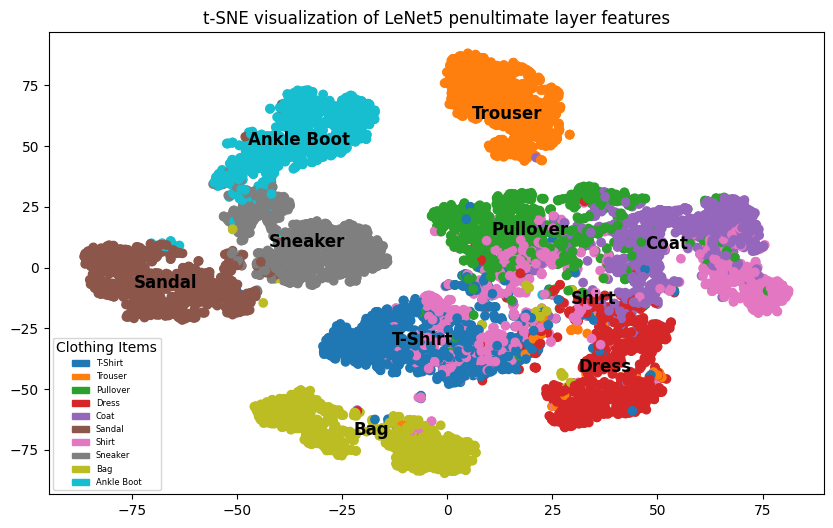

In [11]:
features = []
labels_list = []

model_lenet5.eval()
with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        feature = model_lenet5.get_features(X)
        features.append(feature.cpu().numpy())
        labels_list.append(y.numpy())

features = np.concatenate(features, axis=0)
labels = np.concatenate(labels_list, axis=0)

features = features[::1]
labels = labels[::1]

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=123).fit_transform(features)

# Create a color map with distinct colors for each label
custom_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                 '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
custom_cmap = ListedColormap(custom_colors)

# Plotting
plt.figure(figsize=(10, 6))
scatter = plt.scatter(tsne[:, 0], tsne[:, 1], c=labels, cmap=custom_cmap)
plt.title("t-SNE visualization of LeNet5 penultimate layer features")

# Calculate centroids for each class
centroids = {}
for i in range(10):
    indices = labels == i
    centroids[i] = np.mean(tsne[indices], axis=0)
    
# Plot label names at centroids
for i, centroid in centroids.items():
    plt.text(centroid[0], centroid[1], labels_map[i],
             color='black', fontsize=12, fontweight='demi', ha='center', va='center')   
    

# Create a legend
handles = [mpatches.Patch(color=custom_cmap(i), label=labels_map[i]) for i in range(10)]
plt.legend(handles=handles, title="Clothing Items", fontsize="6", loc="lower left")

# Save plot to file
save_path = os.path.join(plots_path +'/', f"tSNE.png")
plt.savefig(save_path, bbox_inches='tight', dpi=300)

plt.show()


### Plot metrics and store model

In [12]:
def plot_train_val_metrics(history, model_name):
    plt.figure(figsize=(10, 4))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss', color='black')
    plt.plot(history['val_loss'], label='Validation Loss', color='red')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Training Accuracy', color='black')
    plt.plot(history['val_acc'], label='Validation Accuracy', color='red')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Add a main title for the whole figure
    plt.suptitle(f"Training and Validation Metrics for {model_name}", fontsize=16, y=1.05)

    # Adjust layout and show plot
    plt.tight_layout()
    
    # Save plot to file
    save_path = os.path.join(plots_path +'/', f"{model_name}_metrics.png")
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    plt.show()


In [13]:
def export_model(model, model_filename):
    model_scripted = torch.jit.script(model)  # Export to TorchScript
    save_path = os.path.join(models_path, model_filename + '.pt')
    model_scripted.save(save_path)  # Save the model

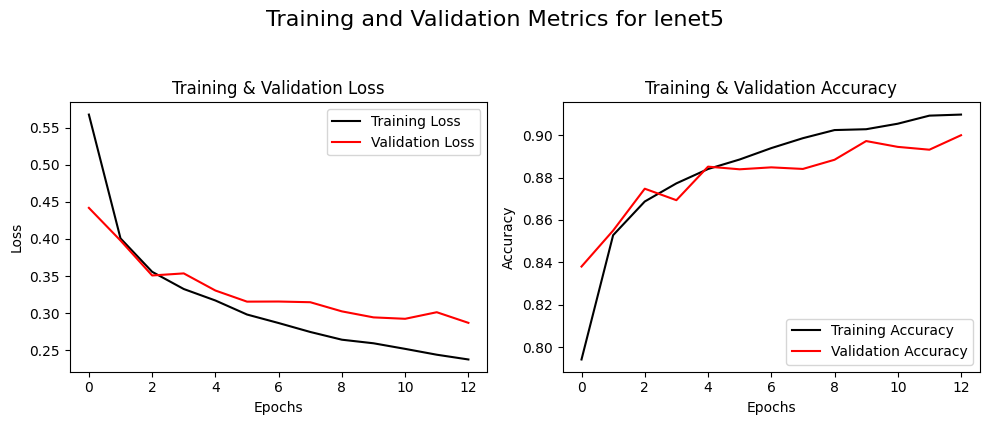

In [14]:
plot_train_val_metrics(history_lenet5, "lenet5")

In [15]:
export_model(model_lenet5, 'lenet5_model_original')

### Evaluation on the test set

In [16]:
test_loss, test_acc = 0, 0
# Same procedure with the validation set
model_lenet5.eval()
with torch.inference_mode():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        y_pred, _, _ = model_lenet5(X)

        test_loss += loss_fn(y_pred, y)
        test_acc += accuracy(y_pred, y)

    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

print(f"Test loss: {test_loss: .5f}| Test acc: {test_acc: .5f}")

Test loss:  0.26451| Test acc:  0.90216


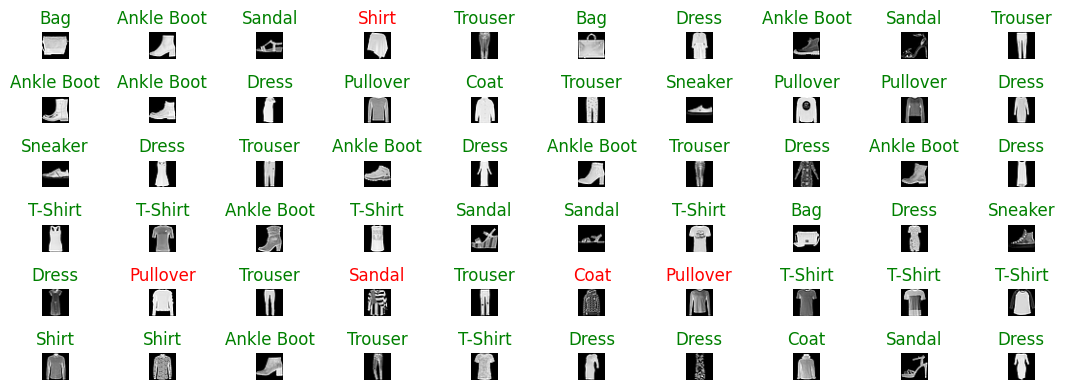

In [17]:
# See random images with their labels
torch.manual_seed(22)  # setting random seed
%matplotlib inline
fig = plt.figure(figsize=(12, 4))

rows, cols = 6, 10
for i in range(1, (rows * cols) + 1):
    random_idx = torch.randint(0, len(test_dataset), size=[1]).item()
    img, label_gt = test_dataset[random_idx]
    img_temp = img.unsqueeze(dim=0).to(device)
    # print(img.shape)
    label_pred = int(torch.argmax(model_lenet5(img_temp)[0]))
    fig.add_subplot(rows, cols, i)
    img = img.permute(1, 2, 0)    # CWH --> WHC
    plt.imshow(img, cmap='gray')
    if label_pred == label_gt:
        plt.title(labels_map[label_pred], color='g') # green label for correct prediction
    else:
        plt.title(labels_map[label_pred], color='r') # red label for incorrect prediction
    plt.axis(False)
    plt.tight_layout();

## Model variants

### 1st variant
Replace average pooling with max pooling

In [18]:
class LeNet5_v1(nn.Module):
    def __init__(self):
        super().__init__()
        self.first_wave = nn.Sequential(
              nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),   # 28x28 -> 32x32 -> 28x28
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2),  # 28x28 -> 14x14
        )

        self.second_wave = nn.Sequential(      
              nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),  # 14x14 -> 10x10
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2),  # 10x10 -> 5x5
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10),
        )
        
        # Initialize weights using Kaiming Uniform
        self._initialize_weights()
        
        # Additional output layers
        self.aux_output1 = nn.Linear(6*14*14, 10)  # After first pooling
        self.aux_output2 = nn.Linear(16*5*5, 10)   # After second pooling

    def forward(self, x):
        x = self.first_wave(x)
        aux1 = self.aux_output1(x.view(x.size(0), -1))
        
        x = self.second_wave(x)
        aux2 = self.aux_output2(x.view(x.size(0), -1))
        
        x = self.classifier(x)
        
        return x, aux1, aux2

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def get_features(self, x):
        # Pass through the first wave of layers
        x = self.first_wave(x)
        
        # Pass through the second wave of layers
        x = self.second_wave(x)
        
        # Flatten the output for the classifier
        x = x.view(x.size(0), -1)

        # Pass through all layers of the classifier except the last one
        for layer in self.classifier[:-1]:
            x = layer(x)

        return x


In [19]:
model_lenet5_v1 = LeNet5_v1()

summary(model=model_lenet5_v1, input_size=(1, 1, 28, 28), col_width=20,
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LeNet5_v1 (LeNet5_v1)                    [1, 1, 28, 28]       [1, 10]              --                   True
├─Sequential (first_wave)                [1, 1, 28, 28]       [1, 6, 14, 14]       --                   True
│    └─Conv2d (0)                        [1, 1, 28, 28]       [1, 6, 28, 28]       156                  True
│    └─ReLU (1)                          [1, 6, 28, 28]       [1, 6, 28, 28]       --                   --
│    └─MaxPool2d (2)                     [1, 6, 28, 28]       [1, 6, 14, 14]       --                   --
├─Linear (aux_output1)                   [1, 1176]            [1, 10]              11,770               True
├─Sequential (second_wave)               [1, 6, 14, 14]       [1, 16, 5, 5]        --                   True
│    └─Conv2d (0)                        [1, 6, 14, 14]       [1, 16, 10, 10]      2,416                True
│    └─ReLU (1)   

In [20]:
# Define Loss Function
loss_fn = nn.CrossEntropyLoss()
# Define Optimizer
optimizer = optim.Adam(model_lenet5_v1.parameters(), lr=0.001)
# Define output accuracy function
accuracy = Accuracy(task='multiclass', num_classes=10)

In [21]:
# Experiment tracking setup using TensorBoard
if TENSORBOARD:
    timestamp = datetime.now().strftime("%Y-%m-%d")
    experiment_name = "MNIST"
    model_name = "LeNet5_v1"
    log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
    writer_v1 = SummaryWriter(log_dir) # Initialize a TensorBoard writer for logging

# Move accuracy and model to the appropriate device
accuracy = accuracy.to(device)
model_lenet5_v1 = model_lenet5_v1.to(device)

history_lenet5_v1 = {'train_loss':[], 'val_loss':[], 'train_acc': [], 'val_acc': []}
epoch_count = 0

best_val_acc = 0.0
best_epoch = 0
best_model_state = None

for epoch in tqdm(range(EPOCHS)): # Progress bar for epochs
    # Initialize trining loss and accuracy
    train_loss_v1, train_acc_v1 = 0.0, 0.0
    
    epoch_count += 1

    # Iterating over batches of training data
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        # Set model to training mode
        model_lenet5_v1.train()
        # Forward pass: compute predictions
        y_pred, _, _ = model_lenet5_v1(X)
        #Calculate the current batch loss and accuracy and aggregate it to the total variables
        loss = loss_fn(y_pred, y)
        train_loss_v1 += loss.item()
        acc = accuracy(y_pred, y)
        train_acc_v1 += acc
        # Zero out gradients
        optimizer.zero_grad()
        # Backpropagate the loss
        loss.backward()
        # Update model parameters
        optimizer.step()

    # Average training loss and accuracy over all batches
    train_loss_v1 /= len(train_loader)
    train_acc_v1 /= len(train_loader)
    # Keep history
    history_lenet5_v1['train_loss'].append(train_loss_v1)
    history_lenet5_v1['train_acc'].append(train_acc_v1)

    # Validation loop
    val_loss_v1, val_acc_v1 = 0.0, 0.0
    # Set model to evaluation mode
    model_lenet5_v1.eval()
    with torch.inference_mode(): # Context manager for inference without gradient tracking
        for X, y in validation_loader:
            X, y = X.to(device), y.to(device)

            y_pred, _, _ = model_lenet5_v1(X)

            loss = loss_fn(y_pred, y)
            val_loss_v1 += loss.item()

            acc = accuracy(y_pred, y)
            val_acc_v1 += acc

        # Average validation loss and accuracy over all batches
        val_loss_v1 /= len(validation_loader)
        val_acc_v1 /= len(validation_loader)
        # Keep history
        history_lenet5_v1['val_loss'].append(val_loss_v1)
        history_lenet5_v1['val_acc'].append(val_acc_v1)
        
        # Check if the validation accuracy improved
        if val_acc_v1 > best_val_acc:
            best_val_acc = val_acc_v1
            # Save the best model state
            best_epoch = epoch
            best_model_state = model_lenet5_v1.state_dict()

    if TENSORBOARD:
        # Log training and validation loss and accuracy to TensorBoard
        writer_v1.add_scalars(main_tag="Loss_v1", tag_scalar_dict={"train_v1/loss_v1": train_loss_v1, "val_v1/loss_v1": val_loss_v1}, global_step=epoch)
        writer_v1.add_scalars(main_tag="Accuracy_v1", tag_scalar_dict={"train_v1/acc_v1": train_acc_v1, "val_v1/acc_v1": val_acc_v1}, global_step=epoch)

    print(f"Epoch: {epoch}| Train loss: {train_loss_v1: .5f}| Train acc: {train_acc_v1: .5f}| Val loss: {val_loss_v1: .5f}| Val acc: {val_acc_v1: .5f}")
    
# After training
if best_model_state is not None:
    model_lenet5_v1.load_state_dict(best_model_state)
    # Cut the history up to the best epoch
    history_lenet5_v1['train_loss'] = history_lenet5_v1['train_loss'][:best_epoch + 1]
    history_lenet5_v1['train_acc'] = history_lenet5_v1['train_acc'][:best_epoch + 1]
    history_lenet5_v1['val_loss'] = history_lenet5_v1['val_loss'][:best_epoch + 1]
    history_lenet5_v1['val_acc'] = history_lenet5_v1['val_acc'][:best_epoch + 1]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0| Train loss:  0.58439| Train acc:  0.78765| Val loss:  0.44300| Val acc:  0.83842
Epoch: 1| Train loss:  0.40930| Train acc:  0.85017| Val loss:  0.40193| Val acc:  0.84992
Epoch: 2| Train loss:  0.36458| Train acc:  0.86669| Val loss:  0.36570| Val acc:  0.86308
Epoch: 3| Train loss:  0.33610| Train acc:  0.87517| Val loss:  0.34647| Val acc:  0.87292
Epoch: 4| Train loss:  0.32071| Train acc:  0.88073| Val loss:  0.33942| Val acc:  0.87458
Epoch: 5| Train loss:  0.30502| Train acc:  0.88669| Val loss:  0.34275| Val acc:  0.87425
Epoch: 6| Train loss:  0.29088| Train acc:  0.89327| Val loss:  0.32875| Val acc:  0.88025
Epoch: 7| Train loss:  0.28360| Train acc:  0.89425| Val loss:  0.31783| Val acc:  0.88358
Epoch: 8| Train loss:  0.27204| Train acc:  0.89812| Val loss:  0.34878| Val acc:  0.87267
Epoch: 9| Train loss:  0.26737| Train acc:  0.89910| Val loss:  0.32828| Val acc:  0.88108
Epoch: 10| Train loss:  0.25888| Train acc:  0.90302| Val loss:  0.30955| Val acc:  0.8865

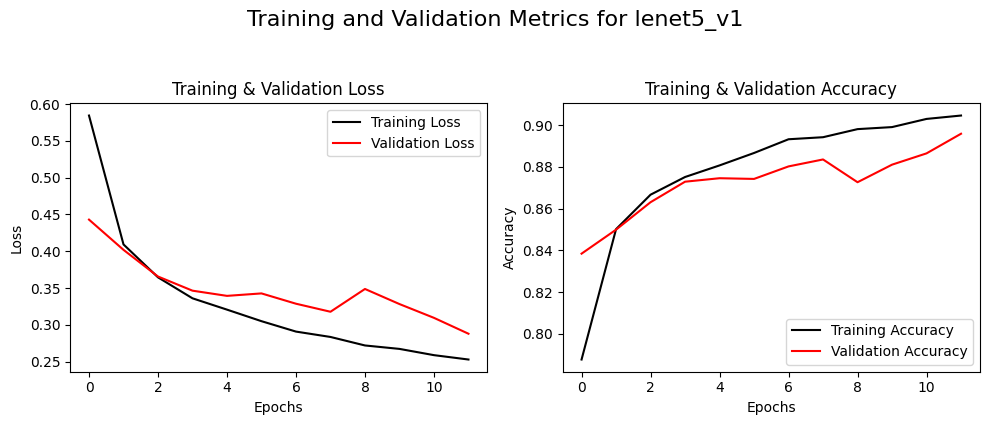

In [24]:
plot_train_val_metrics(history_lenet5_v1, "lenet5_v1")

In [25]:
export_model(model_lenet5_v1, 'lenet5_model_v1')

### 2nd variant
Change learning rate to adaptive learning rate (1/2 every 5 epochs)

In [26]:
# Decreasing learning rate function
def decrease_lr(model, rate):
    print(f"lr decreased from {rate}, to {rate/2}")
    return optim.Adam(model.parameters(), lr=rate/2)

In [91]:
class LeNet5_v2(nn.Module):
    def __init__(self):
        super().__init__()
        self.first_wave = nn.Sequential(
              nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),   # 28x28 -> 32x32 -> 28x28
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2),  # 28x28 -> 14x14
        )

        self.second_wave = nn.Sequential(      
              nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),  # 14x14 -> 10x10
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2),  # 10x10 -> 5x5
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10),
        )
        
        # Initialize weights using Kaiming Uniform
        self._initialize_weights()
        
        # Additional output layers
        self.aux_output1 = nn.Linear(6*14*14, 10)  # After first pooling
        self.aux_output2 = nn.Linear(16*5*5, 10)   # After second pooling

    def forward(self, x):
        x = self.first_wave(x)
        aux1 = self.aux_output1(x.view(x.size(0), -1))
        
        x = self.second_wave(x)
        aux2 = self.aux_output2(x.view(x.size(0), -1))
        
        x = self.classifier(x)
        
        return x, aux1, aux2

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def get_features(self, x):
        # Pass through the first wave of layers
        x = self.first_wave(x)
        
        # Pass through the second wave of layers
        x = self.second_wave(x)
        
        # Flatten the output for the classifier
        x = x.view(x.size(0), -1)

        # Pass through all layers of the classifier except the last one
        for layer in self.classifier[:-1]:
            x = layer(x)

        return x


In [92]:
model_lenet5_v2 = LeNet5_v2()

summary(model=model_lenet5_v2, input_size=(1, 1, 28, 28), col_width=20,
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LeNet5_v2 (LeNet5_v2)                    [1, 1, 28, 28]       [1, 10]              --                   True
├─Sequential (first_wave)                [1, 1, 28, 28]       [1, 6, 14, 14]       --                   True
│    └─Conv2d (0)                        [1, 1, 28, 28]       [1, 6, 28, 28]       156                  True
│    └─ReLU (1)                          [1, 6, 28, 28]       [1, 6, 28, 28]       --                   --
│    └─MaxPool2d (2)                     [1, 6, 28, 28]       [1, 6, 14, 14]       --                   --
├─Linear (aux_output1)                   [1, 1176]            [1, 10]              11,770               True
├─Sequential (second_wave)               [1, 6, 14, 14]       [1, 16, 5, 5]        --                   True
│    └─Conv2d (0)                        [1, 6, 14, 14]       [1, 16, 10, 10]      2,416                True
│    └─ReLU (1)   

In [93]:
# Define Loss Function
loss_fn = nn.CrossEntropyLoss()
# Define Optimizer
optimizer = optim.Adam(model_lenet5_v2.parameters(), lr=0.001)
# Define output accuracy function
accuracy = Accuracy(task='multiclass', num_classes=10)

scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

In [94]:
# Experiment tracking setup using TensorBoard
if TENSORBOARD:
    timestamp = datetime.now().strftime("%Y-%m-%d")
    experiment_name = "MNIST"
    model_name = "LeNet5_v2"
    log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
    writer_v2 = SummaryWriter(log_dir) # Initialize a TensorBoard writer for logging

# Move accuracy and model to the appropriate device
accuracy = accuracy.to(device)
model_lenet5_v2 = model_lenet5_v2.to(device)

history_lenet5_v2 = {'train_loss':[], 'val_loss':[], 'train_acc': [], 'val_acc': []}
epoch_count = 0

learning_rates = []

best_val_acc = 0.0
best_epoch = 0
best_model_state = None

for epoch in tqdm(range(EPOCHS)): # Progress bar for epochs
    # Initialize trining loss and accuracy
    train_loss_v2, train_acc_v2 = 0.0, 0.0
    
    epoch_count += 1

    # Iterating over batches of training data
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        # Set model to training mode
        model_lenet5_v2.train()
        # Forward pass: compute predictions
        y_pred, _, _ = model_lenet5_v2(X)
        #Calculate the current batch loss and accuracy and aggregate it to the total variables
        loss = loss_fn(y_pred, y)
        train_loss_v2 += loss.item()
        acc = accuracy(y_pred, y)
        train_acc_v2 += acc
        # Zero out gradients
        optimizer.zero_grad()
        # Backpropagate the loss
        loss.backward()
        # Update model parameters
        optimizer.step()

    # Average training loss and accuracy over all batches
    train_loss_v2 /= len(train_loader)
    train_acc_v2 /= len(train_loader)
    # Keep history
    history_lenet5_v2['train_loss'].append(train_loss_v2)
    history_lenet5_v2['train_acc'].append(train_acc_v2)

    # Validation loop
    val_loss_v2, val_acc_v2 = 0.0, 0.0
    # Set model to evaluation mode
    model_lenet5_v2.eval()
    with torch.inference_mode(): # Context manager for inference without gradient tracking
        for X, y in validation_loader:
            X, y = X.to(device), y.to(device)

            y_pred, _, _ = model_lenet5_v2(X)

            loss = loss_fn(y_pred, y)
            val_loss_v2 += loss.item()

            acc = accuracy(y_pred, y)
            val_acc_v2 += acc

        # Average validation loss and accuracy over all batches
        val_loss_v2 /= len(validation_loader)
        val_acc_v2 /= len(validation_loader)
        # Keep history
        history_lenet5_v2['val_loss'].append(val_loss_v2)
        history_lenet5_v2['val_acc'].append(val_acc_v2)
        
        # Check if the validation accuracy improved
        if val_acc_v2 > best_val_acc:
            best_val_acc = val_acc_v2
            # Save the best model state
            best_epoch = epoch
            best_model_state = model_lenet5_v2.state_dict()

    if TENSORBOARD:
        # Log training and validation loss and accuracy to TensorBoard
        writer_v2.add_scalars(main_tag="Loss_v2", tag_scalar_dict={"train_v2/loss_v2": train_loss_v2, "val_v2/loss_v2": val_loss_v2}, global_step=epoch)
        writer_v2.add_scalars(main_tag="Accuracy_v2", tag_scalar_dict={"train_v2/acc_v24": train_acc_v2, "val_v2/acc_v2": val_acc_v2}, global_step=epoch)

    print(f"Epoch: {epoch}| Train loss: {train_loss_v2: .5f}| Train acc: {train_acc_v2: .5f}| Val loss: {val_loss_v2: .5f}| Val acc: {val_acc_v2: .5f}")
    
    # Decrease Learning Rate
    scheduler.step()
    
# After training
if best_model_state is not None:
    model_lenet5_v2.load_state_dict(best_model_state)
    # Cut the history up to the best epoch
    history_lenet5_v2['train_loss'] = history_lenet5_v2['train_loss'][:best_epoch + 1]
    history_lenet5_v2['train_acc'] = history_lenet5_v2['train_acc'][:best_epoch + 1]
    history_lenet5_v2['val_loss'] = history_lenet5_v2['val_loss'][:best_epoch + 1]
    history_lenet5_v2['val_acc'] = history_lenet5_v2['val_acc'][:best_epoch + 1]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0| Train loss:  0.60885| Train acc:  0.78171| Val loss:  0.46228| Val acc:  0.83267
Epoch: 1| Train loss:  0.41533| Train acc:  0.84798| Val loss:  0.38785| Val acc:  0.85800
Epoch: 2| Train loss:  0.37244| Train acc:  0.86396| Val loss:  0.38198| Val acc:  0.85692
Epoch: 3| Train loss:  0.34196| Train acc:  0.87473| Val loss:  0.35346| Val acc:  0.86975
Epoch: 4| Train loss:  0.32701| Train acc:  0.87729| Val loss:  0.36241| Val acc:  0.86475
Epoch: 5| Train loss:  0.28706| Train acc:  0.89269| Val loss:  0.31569| Val acc:  0.88150
Epoch: 6| Train loss:  0.27321| Train acc:  0.89860| Val loss:  0.30371| Val acc:  0.88792
Epoch: 7| Train loss:  0.26637| Train acc:  0.90073| Val loss:  0.31260| Val acc:  0.88583
Epoch: 8| Train loss:  0.25990| Train acc:  0.90385| Val loss:  0.31011| Val acc:  0.88658
Epoch: 9| Train loss:  0.25046| Train acc:  0.90688| Val loss:  0.30390| Val acc:  0.89008
Epoch: 10| Train loss:  0.23318| Train acc:  0.91342| Val loss:  0.29724| Val acc:  0.8910

In [31]:
# Plot learning rate through time
def plot_adaptive_lr(lr_per_epoch):
    # Plot learning rate
    plt.plot(lr_per_epoch)
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.title('Adaptive Learning Rate During Training')

    # Save plot to file
    save_path = os.path.join(plots_path +'/', "adaptive_lr.png")
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    plt.show()

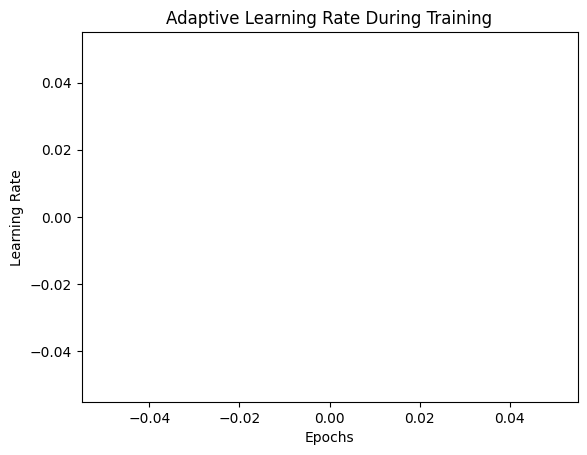

In [71]:
plot_adaptive_lr(learning_rates)

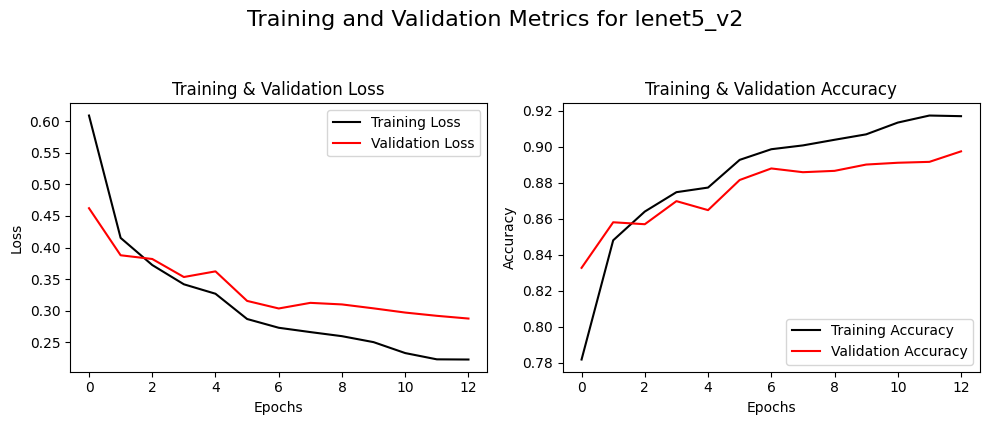

In [95]:
plot_train_val_metrics(history_lenet5_v2, "lenet5_v2")

In [96]:
export_model(model_lenet5_v2, 'lenet5_model_v2')

### 3rd variant
Increase number of filters in convolution layers from 6 and 16 to 32 and 64

In [84]:
class LeNet5_v3(nn.Module):
    def __init__(self):
        super().__init__()
        self.first_wave = nn.Sequential(
              nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2),   # 28x28 -> 32x32 -> 28x28
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2),  # 28x28 -> 14x14
        )

        self.second_wave = nn.Sequential(      
              nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1),  # 14x14 -> 10x10
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2),  # 10x10 -> 5x5
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=64*5*5, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10),
        )
        
        # Initialize weights using Kaiming Uniform
        self._initialize_weights()
        
        # Additional output layers
        self.aux_output1 = nn.Linear(32*14*14, 10)  # After first pooling
        self.aux_output2 = nn.Linear(64*5*5, 10)   # After second pooling

    def forward(self, x):
        x = self.first_wave(x)
        aux1 = self.aux_output1(x.view(x.size(0), -1))
        
        x = self.second_wave(x)
        aux2 = self.aux_output2(x.view(x.size(0), -1))
        
        x = self.classifier(x)
        
        return x, aux1, aux2

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def get_features(self, x):
        # Pass through the first wave of layers
        x = self.first_wave(x)
        
        # Pass through the second wave of layers
        x = self.second_wave(x)
        
        # Flatten the output for the classifier
        x = x.view(x.size(0), -1)

        # Pass through all layers of the classifier except the last one
        for layer in self.classifier[:-1]:
            x = layer(x)

        return x


In [85]:
model_lenet5_v3 = LeNet5_v3()

summary(model=model_lenet5_v3, input_size=(1, 1, 28, 28), col_width=20,
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LeNet5_v3 (LeNet5_v3)                    [1, 1, 28, 28]       [1, 10]              --                   True
├─Sequential (first_wave)                [1, 1, 28, 28]       [1, 32, 14, 14]      --                   True
│    └─Conv2d (0)                        [1, 1, 28, 28]       [1, 32, 28, 28]      832                  True
│    └─ReLU (1)                          [1, 32, 28, 28]      [1, 32, 28, 28]      --                   --
│    └─MaxPool2d (2)                     [1, 32, 28, 28]      [1, 32, 14, 14]      --                   --
├─Linear (aux_output1)                   [1, 6272]            [1, 10]              62,730               True
├─Sequential (second_wave)               [1, 32, 14, 14]      [1, 64, 5, 5]        --                   True
│    └─Conv2d (0)                        [1, 32, 14, 14]      [1, 64, 10, 10]      51,264               True
│    └─ReLU (1)   

In [86]:
# Define Loss Function
loss_fn = nn.CrossEntropyLoss()
# Define Optimizer
optimizer = optim.Adam(model_lenet5_v3.parameters(), lr=0.001)
# Define output accuracy function
accuracy = Accuracy(task='multiclass', num_classes=10)

scheduler = StepLR(optimizer, step_size=5, gamma=0.5)


In [87]:
# Experiment tracking setup using TensorBoard
if TENSORBOARD:
    timestamp = datetime.now().strftime("%Y-%m-%d")
    experiment_name = "MNIST"
    model_name = "LeNet5_v3"
    log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
    writer_v3 = SummaryWriter(log_dir) # Initialize a TensorBoard writer for logging

# Move accuracy and model to the appropriate device
accuracy = accuracy.to(device)
model_lenet5_v3 = model_lenet5_v3.to(device)

history_lenet5_v3 = {'train_loss':[], 'val_loss':[], 'train_acc': [], 'val_acc': []}
epoch_count = 0

best_val_acc = 0.0
best_epoch = 0
best_model_state = None

for epoch in tqdm(range(EPOCHS)): # Progress bar for epochs
    # Initialize trining loss and accuracy
    train_loss_v3, train_acc_v3 = 0.0, 0.0
    
    
    
    epoch_count += 1

    # Iterating over batches of training data
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        # Set model to training mode
        model_lenet5_v3.train()
        # Forward pass: compute predictions
        y_pred, _, _ = model_lenet5_v3(X)
        #Calculate the current batch loss and accuracy and aggregate it to the total variables
        loss = loss_fn(y_pred, y)
        train_loss_v3 += loss.item()
        acc = accuracy(y_pred, y)
        train_acc_v3 += acc
        # Zero out gradients
        optimizer.zero_grad()
        # Backpropagate the loss
        loss.backward()
        # Update model parameters
        optimizer.step()

    # Average training loss and accuracy over all batches
    train_loss_v3 /= len(train_loader)
    train_acc_v3 /= len(train_loader)
    # Keep history
    history_lenet5_v3['train_loss'].append(train_loss_v3)
    history_lenet5_v3['train_acc'].append(train_acc_v3)

    # Validation loop
    val_loss_v3, val_acc_v3 = 0.0, 0.0
    # Set model to evaluation mode
    model_lenet5_v3.eval()
    with torch.inference_mode(): # Context manager for inference without gradient tracking
        for X, y in validation_loader:
            X, y = X.to(device), y.to(device)

            y_pred, _, _ = model_lenet5_v3(X)

            loss = loss_fn(y_pred, y)
            val_loss_v3 += loss.item()

            acc = accuracy(y_pred, y)
            val_acc_v3 += acc

        # Average validation loss and accuracy over all batches
        val_loss_v3 /= len(validation_loader)
        val_acc_v3 /= len(validation_loader)
        # Keep history
        history_lenet5_v3['val_loss'].append(val_loss_v3)
        history_lenet5_v3['val_acc'].append(val_acc_v3)
        
        # Check if the validation accuracy improved
        if val_acc_v3 > best_val_acc:
            best_val_acc = val_acc_v3
            # Save the best model state
            best_epoch = epoch
            best_model_state = model_lenet5_v3.state_dict()

    if TENSORBOARD:
        # Log training and validation loss and accuracy to TensorBoard
        writer_v3.add_scalars(main_tag="Loss_v3", tag_scalar_dict={"train_v3/loss_v3": train_loss_v3, "val_v3/loss_v3": val_loss_v3}, global_step=epoch)
        writer_v3.add_scalars(main_tag="Accuracy_v3", tag_scalar_dict={"train_v3/acc_v3": train_acc_v3, "val_v3/acc_v3": val_acc_v3}, global_step=epoch)

    print(f"Epoch: {epoch}| Train loss: {train_loss_v3: .5f}| Train acc: {train_acc_v3: .5f}| Val loss: {val_loss_v3: .5f}| Val acc: {val_acc_v3: .5f}")
    # Decrease the learning rate by 1/2
    scheduler.step()
    
if best_model_state is not None:
    model_lenet5_v3.load_state_dict(best_model_state)
    # Cut the history up to the best epoch
    history_lenet5_v3['train_loss'] = history_lenet5_v3['train_loss'][:best_epoch + 1]
    history_lenet5_v3['train_acc'] = history_lenet5_v3['train_acc'][:best_epoch + 1]
    history_lenet5_v3['val_loss'] = history_lenet5_v3['val_loss'][:best_epoch + 1]
    history_lenet5_v3['val_acc'] = history_lenet5_v3['val_acc'][:best_epoch + 1]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0| Train loss:  0.52916| Train acc:  0.81150| Val loss:  0.37735| Val acc:  0.86692
Epoch: 1| Train loss:  0.35993| Train acc:  0.86746| Val loss:  0.34896| Val acc:  0.87442
Epoch: 2| Train loss:  0.32093| Train acc:  0.88319| Val loss:  0.32374| Val acc:  0.88400
Epoch: 3| Train loss:  0.29468| Train acc:  0.89104| Val loss:  0.32088| Val acc:  0.87983
Epoch: 4| Train loss:  0.27152| Train acc:  0.90094| Val loss:  0.29801| Val acc:  0.89217
Epoch: 5| Train loss:  0.22829| Train acc:  0.91656| Val loss:  0.26768| Val acc:  0.90433
Epoch: 6| Train loss:  0.21690| Train acc:  0.91975| Val loss:  0.27343| Val acc:  0.90433
Epoch: 7| Train loss:  0.20715| Train acc:  0.92371| Val loss:  0.26262| Val acc:  0.90717
Epoch: 8| Train loss:  0.19969| Train acc:  0.92608| Val loss:  0.27459| Val acc:  0.90275
Epoch: 9| Train loss:  0.18834| Train acc:  0.92898| Val loss:  0.25787| Val acc:  0.90883
Epoch: 10| Train loss:  0.16625| Train acc:  0.93888| Val loss:  0.25869| Val acc:  0.9093

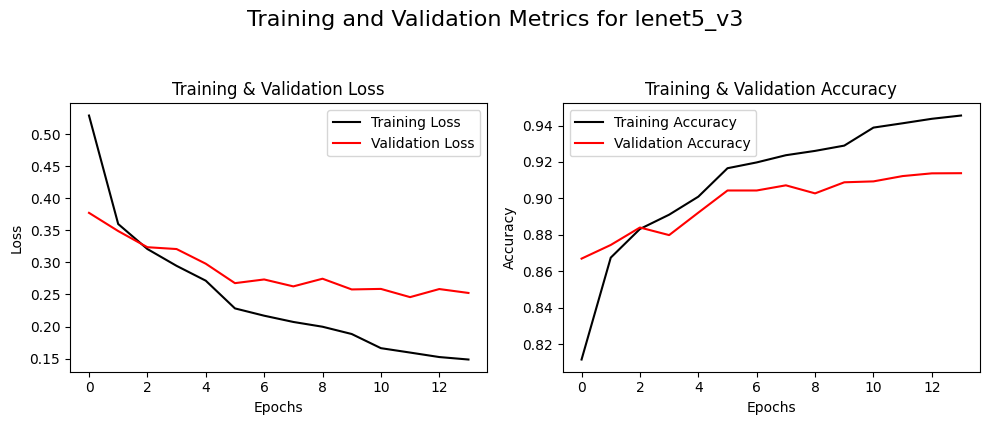

In [88]:
plot_train_val_metrics(history_lenet5_v3, "lenet5_v3")

In [89]:
export_model(model_lenet5_v3, 'lenet5_model_v3')

### 4th variant
Increase neurons in fully connected layers from 120 and 84 to 200 and 140 (maintain 0.7 ratio)

In [97]:
class LeNet5_v4(nn.Module):
    def __init__(self):
        super().__init__()
        self.first_wave = nn.Sequential(
              nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2),   # 28x28 -> 32x32 -> 28x28
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2),  # 28x28 -> 14x14
        )

        self.second_wave = nn.Sequential(      
              nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1),  # 14x14 -> 10x10
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2),  # 10x10 -> 5x5
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=64*5*5, out_features=200),
            nn.ReLU(),
            nn.Linear(in_features=200, out_features=140),
            nn.ReLU(),
            nn.Linear(in_features=140, out_features=10),
        )
        
        # Initialize weights using Kaiming Uniform
        self._initialize_weights()
        
        # Additional output layers
        self.aux_output1 = nn.Linear(32*14*14, 10)  # After first pooling
        self.aux_output2 = nn.Linear(64*5*5, 10)   # After second pooling

    def forward(self, x):
        x = self.first_wave(x)
        aux1 = self.aux_output1(x.view(x.size(0), -1))
        
        x = self.second_wave(x)
        aux2 = self.aux_output2(x.view(x.size(0), -1))
        
        x = self.classifier(x)
        
        return x, aux1, aux2

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def get_features(self, x):
        # Pass through the first wave of layers
        x = self.first_wave(x)
        
        # Pass through the second wave of layers
        x = self.second_wave(x)
        
        # Flatten the output for the classifier
        x = x.view(x.size(0), -1)

        # Pass through all layers of the classifier except the last one
        for layer in self.classifier[:-1]:
            x = layer(x)

        return x


In [98]:
model_lenet5_v4 = LeNet5_v4()

summary(model=model_lenet5_v4, input_size=(1, 1, 28, 28), col_width=20,
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LeNet5_v4 (LeNet5_v4)                    [1, 1, 28, 28]       [1, 10]              --                   True
├─Sequential (first_wave)                [1, 1, 28, 28]       [1, 32, 14, 14]      --                   True
│    └─Conv2d (0)                        [1, 1, 28, 28]       [1, 32, 28, 28]      832                  True
│    └─ReLU (1)                          [1, 32, 28, 28]      [1, 32, 28, 28]      --                   --
│    └─MaxPool2d (2)                     [1, 32, 28, 28]      [1, 32, 14, 14]      --                   --
├─Linear (aux_output1)                   [1, 6272]            [1, 10]              62,730               True
├─Sequential (second_wave)               [1, 32, 14, 14]      [1, 64, 5, 5]        --                   True
│    └─Conv2d (0)                        [1, 32, 14, 14]      [1, 64, 10, 10]      51,264               True
│    └─ReLU (1)   

In [99]:
# Define Loss Function
loss_fn = nn.CrossEntropyLoss()
# Define Optimizer
optimizer = optim.Adam(model_lenet5_v4.parameters(), lr=0.001, weight_decay=1e-4)
# Define output accuracy function
accuracy = Accuracy(task='multiclass', num_classes=10)

scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

In [100]:
# Experiment tracking setup using TensorBoard
if TENSORBOARD:
    timestamp = datetime.now().strftime("%Y-%m-%d")
    experiment_name = "MNIST"
    model_name = "LeNet5_v4"
    log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
    writer_v4 = SummaryWriter(log_dir) # Initialize a TensorBoard writer for logging

# Move accuracy and model to the appropriate device
accuracy = accuracy.to(device)
model_lenet5_v4 = model_lenet5_v4.to(device)

history_lenet5_v4 = {'train_loss':[], 'val_loss':[], 'train_acc': [], 'val_acc': []}
epoch_count = 0

best_val_acc = 0.0
best_epoch = 0
best_model_state = None

for epoch in tqdm(range(EPOCHS)): # Progress bar for epochs
    # Initialize trining loss and accuracy
    train_loss_v4, train_acc_v4 = 0.0, 0.0
    
    epoch_count += 1

    # Iterating over batches of training data
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        # Set model to training mode
        model_lenet5_v4.train()
        # Forward pass: compute predictions
        y_pred, _, _ = model_lenet5_v4(X)
        #Calculate the current batch loss and accuracy and aggregate it to the total variables
        loss = loss_fn(y_pred, y)
        train_loss_v4 += loss.item()
        acc = accuracy(y_pred, y)
        train_acc_v4 += acc
        # Zero out gradients
        optimizer.zero_grad()
        # Backpropagate the loss
        loss.backward()
        # Update model parameters
        optimizer.step()

    # Average training loss and accuracy over all batches
    train_loss_v4 /= len(train_loader)
    train_acc_v4 /= len(train_loader)
    # Keep history
    history_lenet5_v4['train_loss'].append(train_loss_v4)
    history_lenet5_v4['train_acc'].append(train_acc_v4)

    # Validation loop
    val_loss_v4, val_acc_v4 = 0.0, 0.0
    # Set model to evaluation mode
    model_lenet5_v4.eval()
    with torch.inference_mode(): # Context manager for inference without gradient tracking
        for X, y in validation_loader:
            X, y = X.to(device), y.to(device)

            y_pred, _, _ = model_lenet5_v4(X)

            loss = loss_fn(y_pred, y)
            val_loss_v4 += loss.item()

            acc = accuracy(y_pred, y)
            val_acc_v4 += acc

        # Average validation loss and accuracy over all batches
        val_loss_v4 /= len(validation_loader)
        val_acc_v4 /= len(validation_loader)
        # Keep history
        history_lenet5_v4['val_loss'].append(val_loss_v4)
        history_lenet5_v4['val_acc'].append(val_acc_v4)
        
        # Check if the validation accuracy improved
        if val_acc_v4 > best_val_acc:
            best_val_acc = val_acc_v4
            # Save the best model state
            best_epoch = epoch
            best_model_state = model_lenet5_v4.state_dict()
        
    if TENSORBOARD:
    # Log training and validation loss and accuracy to TensorBoard
        writer_v4.add_scalars(main_tag="Loss_v4", tag_scalar_dict={"train_v4/loss_v4": train_loss_v4, "val_v4/loss_v4": val_loss_v4}, global_step=epoch)
        writer_v4.add_scalars(main_tag="Accuracy_v4", tag_scalar_dict={"train_v4/acc_v4": train_acc_v4, "val_v4/acc_v4": val_acc_v4}, global_step=epoch)

    print(f"Epoch: {epoch}| Train loss: {train_loss_v4: .5f}| Train acc: {train_acc_v4: .5f}| Val loss: {val_loss_v4: .5f}| Val acc: {val_acc_v4: .5f}")
    
    # Decrease Learning Rate
    scheduler.step()
    
# After training
if best_model_state is not None:
    model_lenet5_v4.load_state_dict(best_model_state)
    # Cut the history up to the best epoch
    history_lenet5_v4['train_loss'] = history_lenet5_v4['train_loss'][:best_epoch + 1]
    history_lenet5_v4['train_acc'] = history_lenet5_v4['train_acc'][:best_epoch + 1]
    history_lenet5_v4['val_loss'] = history_lenet5_v4['val_loss'][:best_epoch + 1]
    history_lenet5_v4['val_acc'] = history_lenet5_v4['val_acc'][:best_epoch + 1]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0| Train loss:  0.49717| Train acc:  0.81892| Val loss:  0.38237| Val acc:  0.86233
Epoch: 1| Train loss:  0.34846| Train acc:  0.87112| Val loss:  0.33694| Val acc:  0.87392
Epoch: 2| Train loss:  0.31165| Train acc:  0.88473| Val loss:  0.32801| Val acc:  0.87975
Epoch: 3| Train loss:  0.28620| Train acc:  0.89442| Val loss:  0.29558| Val acc:  0.89167
Epoch: 4| Train loss:  0.26597| Train acc:  0.90090| Val loss:  0.33200| Val acc:  0.88425
Epoch: 5| Train loss:  0.22085| Train acc:  0.91748| Val loss:  0.25575| Val acc:  0.90675
Epoch: 6| Train loss:  0.20869| Train acc:  0.92196| Val loss:  0.26783| Val acc:  0.90267
Epoch: 7| Train loss:  0.19748| Train acc:  0.92619| Val loss:  0.25797| Val acc:  0.90767
Epoch: 8| Train loss:  0.18634| Train acc:  0.92998| Val loss:  0.25340| Val acc:  0.90967
Epoch: 9| Train loss:  0.18150| Train acc:  0.93152| Val loss:  0.25736| Val acc:  0.90842
Epoch: 10| Train loss:  0.15317| Train acc:  0.94225| Val loss:  0.25011| Val acc:  0.9175

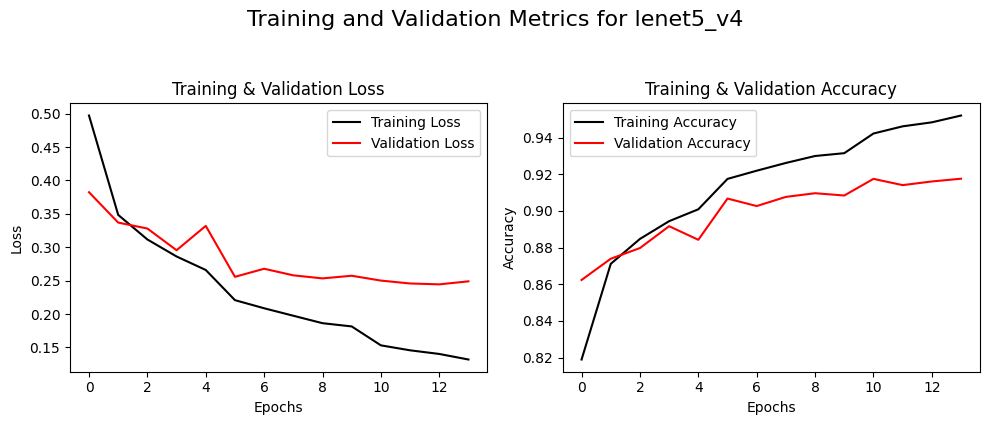

In [105]:
plot_train_val_metrics(history_lenet5_v4, "lenet5_v4")

In [106]:
export_model(model_lenet5_v4, 'lenet5_model_v4')

## Store results in CSV

In [107]:
model_metrics = {
    'lenet5_model_original': {'train_loss': history_lenet5['train_loss'][-1], 
                              'val_loss': history_lenet5['val_loss'][-1], 
                              'train_acc': history_lenet5['train_acc'][-1], 
                              'val_acc': history_lenet5['val_acc'][-1]},
    'lenet5_model_v1': {'train_loss': history_lenet5_v1['train_loss'][-1], 
                        'val_loss': history_lenet5_v1['val_loss'][-1], 
                        'train_acc': history_lenet5_v1['train_acc'][-1], 
                        'val_acc': history_lenet5_v1['val_acc'][-1]},
    'lenet5_model_v2': {'train_loss': history_lenet5_v2['train_loss'][-1], 
                        'val_loss': history_lenet5_v2['val_loss'][-1], 
                        'train_acc': history_lenet5_v2['train_acc'][-1], 
                        'val_acc': history_lenet5_v2['val_acc'][-1]},
    'lenet5_model_v3': {'train_loss': history_lenet5_v3['train_loss'][-1], 
                        'val_loss': history_lenet5_v3['val_loss'][-1], 
                        'train_acc': history_lenet5_v3['train_acc'][-1], 
                        'val_acc': history_lenet5_v3['val_acc'][-1]},
    'lenet5_model_v4': {'train_loss': history_lenet5_v4['train_loss'][-1], 
                        'val_loss': history_lenet5_v4['val_loss'][-1], 
                        'train_acc': history_lenet5_v4['train_acc'][-1], 
                        'val_acc': history_lenet5_v4['val_acc'][-1]},
}

In [108]:
def create_csv(model_metrics, filename):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        
        # Write the header
        header = ['Model', 'Train Loss', 'Validation Loss', 'Train Accuracy', 'Validation Accuracy']
        writer.writerow(header)

        # Write the data for each model
        for model_name, metrics in model_metrics.items():
            row = [
                model_name,
                metrics['train_loss'],
                metrics['val_loss'],
                metrics['train_acc'].item() if torch.is_tensor(metrics['train_acc']) else metrics['train_acc'],
                metrics['val_acc'].item() if torch.is_tensor(metrics['val_acc']) else metrics['val_acc']
            ]
            writer.writerow(row)

create_csv(model_metrics, 'final_model_metrics.csv')

## Test the model with the highest Validation Accuracy

In [109]:
results = pd.read_csv('final_model_metrics.csv')

# Find the id of the model with the max Validation Accuracy
max_val_acc_id = results['Validation Accuracy'].idxmax()

# Retrieve the row of this specific model
max_model = results.loc[max_val_acc_id]

max_val_acc_formatted = float("{:.3f}".format(max_model["Validation Accuracy"])) *100

print(f'The model with the highest Validation Accuracy ({max_val_acc_formatted}%) is {max_model["Model"]}')

The model with the highest Validation Accuracy (91.8%) is lenet5_model_v4


In [110]:
results

,Model,Train Loss,Validation Loss,Train Accuracy,Validation Accuracy
0,lenet5_model_original,0.237654,0.286996,0.909750,0.900000
1,lenet5_model_v1,0.252941,0.287981,0.904646,0.895917
2,lenet5_model_v2,0.222979,0.287781,0.916979,0.897417
3,lenet5_model_v3,0.148531,0.252369,0.945500,0.913833
4,lenet5_model_v4,0.131960,0.248982,0.952062,0.917583


In [111]:
max_model['Model']

'lenet5_model_v4'

In [112]:
test_loss, test_acc = 0, 0
model_file = f"models/{max_model['Model']}.pt"

# Load the PyTorch model
model = torch.jit.load(model_file)

model.eval()
with torch.inference_mode():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        y_pred, _, _ = model(X)

        test_loss += loss_fn(y_pred, y)
        test_acc += accuracy(y_pred, y)

    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

print(f"Test loss: {test_loss: .5f}| Test acc: {test_acc: .5f}")

Test loss:  0.24421| Test acc:  0.92352


In [ ]:
plot_confusion_matrix(y, y_pred):

    cm = confusion_matrix(y, y_pred)
    ConfusionMatrixDisplay(cm).plot()

## K-fold cross validation

### LeNet baseline with k-fold cross validation

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0| Train loss:  0.63067| Train acc:  0.77323| Val loss:  0.49598| Val acc:  0.81475
Epoch: 1| Train loss:  0.44450| Train acc:  0.83535| Val loss:  0.41422| Val acc:  0.84925
Epoch: 2| Train loss:  0.39852| Train acc:  0.85283| Val loss:  0.38659| Val acc:  0.85750
Epoch: 3| Train loss:  0.36773| Train acc:  0.86360| Val loss:  0.37066| Val acc:  0.86367
Epoch: 4| Train loss:  0.34693| Train acc:  0.87177| Val loss:  0.36581| Val acc:  0.86550
lr decreased from 0.001, to 0.0005
Epoch: 5| Train loss:  0.30813| Train acc:  0.88483| Val loss:  0.33714| Val acc:  0.87550
Epoch: 6| Train loss:  0.29758| Train acc:  0.89121| Val loss:  0.34419| Val acc:  0.87508
Epoch: 7| Train loss:  0.29052| Train acc:  0.89235| Val loss:  0.33333| Val acc:  0.87625
Epoch: 8| Train loss:  0.28398| Train acc:  0.89435| Val loss:  0.32054| Val acc:  0.88183
Epoch: 9| Train loss:  0.27681| Train acc:  0.89640| Val loss:  0.31375| Val acc:  0.88383
lr decreased from 0.0005, to 0.00025
Epoch: 10| Train l

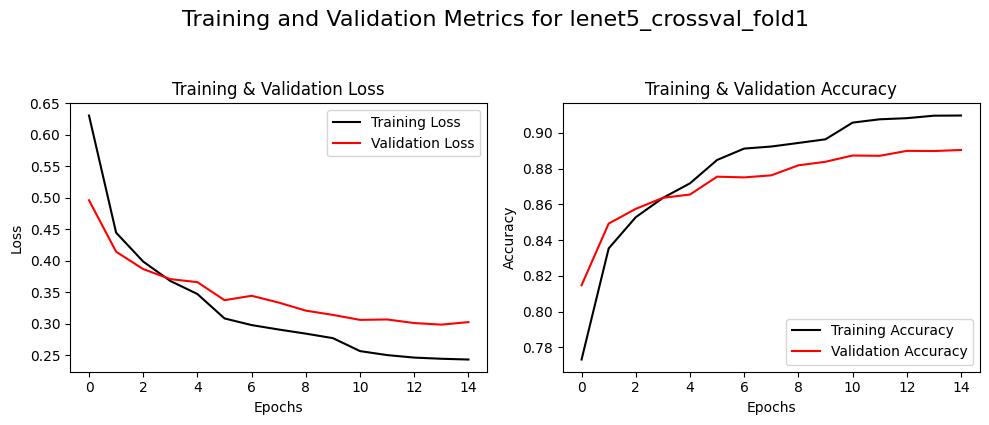

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0| Train loss:  0.62929| Train acc:  0.77237| Val loss:  0.47367| Val acc:  0.82667


KeyboardInterrupt: 

In [35]:
# Initialize results for for k-fold cross validation
kf_results = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

# Initialize the k-fold cross validation
kf = KFold(n_splits=5, shuffle=True)

# Loop through each fold
for fold, (train_idx, test_idx) in enumerate(kf.split(train_val_dataset)):
    # Create data loaders for training and validation sets for fold
    train_loader_fold = torch.utils.data.DataLoader(train_val_dataset, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(train_idx))
    validation_loader_fold = torch.utils.data.DataLoader(train_val_dataset, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(test_idx))

    # Initialize a new model instance for each fold
    model_lenet5 = LeNet5()
    
    # Define Loss Function
    loss_fn = nn.CrossEntropyLoss()
    # Define Optimizer
    optimizer = optim.Adam(model_lenet5.parameters(), lr=0.001)
    # Define output accuracy function
    accuracy = Accuracy(task='multiclass', num_classes=10)

    # Move accuracy and model to the appropriate device
    accuracy = accuracy.to(device)
    model_lenet5 = model_lenet5.to(device)

    # Initialize history for this fold
    history_fold = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    best_val_acc = 0.0
    best_epoch = 0
    best_model_state = None

    epoch_count = 0

    for epoch in tqdm(range(EPOCHS)):  # Progress bar for epochs
        # Initialize trining loss and accuracy
        train_loss, train_acc = 0.0, 0.0

        # Decrease the learning rate by 1/2
        if epoch_count % 5 == 0 and epoch_count > 0:
            optimizer = decrease_lr(model_lenet5, optimizer.defaults['lr'])

        epoch_count += 1

        # Iterating over batches of training data
        for X, y in train_loader_fold:
            X, y = X.to(device), y.to(device)
            # Set model to training mode
            model_lenet5.train()
            # Forward pass: compute predictions
            y_pred, _, _ = model_lenet5.forward(X)
            # Calculate the current batch loss and accuracy and aggregate it to the total variables
            loss = loss_fn(y_pred, y)
            train_loss += loss.item()
            acc = accuracy(y_pred, y)
            train_acc += acc
            # Zero out gradients
            optimizer.zero_grad()
            # Backpropagate the loss
            loss.backward()
            # Update model parameters
            optimizer.step()

        # Average training loss and accuracy over all batches
        train_loss /= len(train_loader_fold)
        train_acc /= len(train_loader_fold)
        # Keep history
        history_fold['train_loss'].append(train_loss)
        history_fold['train_acc'].append(train_acc)

        # Validation loop
        val_loss, val_acc = 0.0, 0.0
        # Set model to evaluation mode
        model_lenet5.eval()
        with torch.inference_mode():  # Context manager for inference without gradient tracking
            for X, y in validation_loader_fold:
                X, y = X.to(device), y.to(device)

                y_pred, _, _ = model_lenet5.forward(X)

                loss = loss_fn(y_pred, y)
                val_loss += loss.item()

                acc = accuracy(y_pred, y)
                val_acc += acc

            # Average validation loss and accuracy over all batches
            val_loss /= len(validation_loader_fold)
            val_acc /= len(validation_loader_fold)
            # Keep history
            history_fold['val_loss'].append(val_loss)
            history_fold['val_acc'].append(val_acc)

            # Check if the validation accuracy improved
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                # Save the best model state
                best_epoch = epoch
                best_model_state = model_lenet5.state_dict()

        print(
            f"Epoch: {epoch}| Train loss: {train_loss: .5f}| Train acc: {train_acc: .5f}| Val loss: {val_loss: .5f}| Val acc: {val_acc: .5f}")

    # Get best state after training the fold
    if best_model_state is not None:
        model_lenet5.load_state_dict(best_model_state)
        history_fold['train_loss'] = history_fold['train_loss'][:best_epoch + 1]
        history_fold['train_acc'] = history_fold['train_acc'][:best_epoch + 1]
        history_fold['val_loss'] = history_fold['val_loss'][:best_epoch + 1]
        history_fold['val_acc'] = history_fold['val_acc'][:best_epoch + 1]

    # Plot results of the fold
    plot_train_val_metrics(history_fold, "lenet5_crossval_fold" + str(fold + 1))

    # Store performance metrics for the fold
    kf_results['train_loss'].append(history_fold['train_loss'][-1])
    kf_results['train_acc'].append(history_fold['train_acc'][-1])
    kf_results['val_loss'].append(history_fold['val_loss'][-1])
    kf_results['val_acc'].append(history_fold['val_acc'][-1])

# Calculate averages across folds
avg_train_loss = np.mean(kf_results['train_loss'])
avg_train_acc = np.mean(kf_results['train_acc'])
avg_val_loss = np.mean(kf_results['val_loss'])
avg_val_acc = np.mean(kf_results['val_acc'])

print('Average Training Loss:', avg_train_loss)
print('Average Training Accuracy:', avg_train_acc)
print('Average Validation Loss:', avg_val_loss)
print('Average Validation Accuracy:', avg_val_acc)

In [ ]:
export_model(model_lenet5, 'lenet5_crossval')